In [13]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn


%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../../')
# import utils
from VisUtils import *
from split_data import *
from RF_Utils import *
# from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def plot_metrics_for_models(results_list, dataset_title):
    """for testing"""
    plt.figure(figsize=(10, 6))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
 
    metric_values = np.zeros((num_models, num_metrics))
    for i, results in enumerate(results_list):
        for j, metric in enumerate(metrics):
            metric_values[i, j] = results['test_'+metric]
    bar_width = 0.15
    index = np.arange(num_models)
    plt.figure(figsize=(10, 6))
    for i in range(num_metrics):
        plt.bar(index + i * bar_width, metric_values[:, i], bar_width, label=metrics[i])

    plt.xlabel('Model Types')
    plt.ylabel('Values')
    plt.title(f'Metrics Across Model Types: {dataset_title}')
    plt.xticks(index + bar_width *(num_metrics - 1)/2, model_names)
    plt.legend()
    plt.show()

In [15]:
def plot_metrics_for_sampling(results_list, dataset_title):
    """for testing"""
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)
    metric_values = np.zeros((num_models, num_metrics))
    bar_width = 0.15
    index = np.arange(num_models)

    for i in range(num_datasets):
        plt.subplot(num_datasets, 1, i+1)
        metric_values = np.zeros((num_models, num_metrics))
        for j, results in enumerate(results_lists[i]):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Model Types')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Model Types: {dataset_titles[i]}')
        plt.xticks(index + bar_width *(num_metrics -1)/2, model_names)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show(); 

In [16]:
def plot_metrics_for_models2(results_lists, titles):
    plt.figure(figsize=(12, 8))
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    metrics = ['acc', 'prec', 'recall', 'specificity']
    num_metrics = len(metrics)
    num_models = len(model_names)
    num_datasets = len(results_lists)

    bar_width = 0.15
    index = np.arange(num_models)
    for i in range(num_models):
        plt.subplot(num_models, 1, i+1)
        metric_values = np.zeros((num_datasets, num_metrics))
        for j, results_list in enumerate(results_lists):
            for k, metric in enumerate(metrics):
                metric_values[j, k] = results_list[i]['test_'+metric]

        for l in range(num_metrics):
            plt.bar(index + l * bar_width, metric_values[:, l], bar_width, label=metrics[l])

        plt.xlabel('Sampling Techniques')
        plt.ylabel('Values')
        plt.title(f'Metrics Across Sampling Techniques for Model Type: {model_names[i]}')
        plt.xticks(index + bar_width * (num_metrics - 1) / 2, dataset_titles)
        plt.legend()
        
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show();


In [17]:
def plot_chosen_metric(results_lists, metric, title):
    model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
    sampling_techniques = ['Original', 'Undersampled', 'SMOTE', 'ADASYN']
    # metrics = ['acc', 'prec', 'recall', 'specificity']
    plt.figure(figsize=(10, 6))
    # for i, model_name in enumerate(model_names):
    #     metric_values = []
    #     for j, results_list in enumerate(results_lists):
    #         metric_values.append(results_list[j]['test_'+metric])

    #     plt.plot(sampling_techniques, metric_values, label=model_name)
    for i, model_results in enumerate(results_lists):
        metric_values = [result['test_'+metric] for result in model_results]
        plt.plot(sampling_techniques, metric_values, label=model_names[i])
    plt.xlabel('Sampling type')
    plt.ylabel('Value')
    plt.title(f'{metric} Results: {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
modeldir = '../saved_models/'

# Load datasets
(MOE descriptors, just scaled)

In [19]:
split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib/'
train_x_df = pd.read_csv(split_path + 'inhib_train_x_scaledoriginal.csv', header=None)
train_y_df = pd.read_csv(split_path + 'inhib_train_y_scaledoriginal.csv', header=None)
test_y_df = pd.read_csv(split_path + 'inhib_test_y_scaledoriginal.csv', header=None)
test_x_df = pd.read_csv(split_path + 'inhib_test_x_scaledoriginal.csv', header=None)
train_x = train_x_df.values
train_y = train_y_df.values.flatten()
test_y = test_y_df.values.flatten()
test_x = test_x_df.values
train_x.shape, train_y.shape, test_y.shape, test_x.shape

((1635, 306), (1635,), (409,), (409, 306))

In [20]:
# UNDER 
train_x_df_UNDER = pd.read_csv(split_path + 'inhib_train_x_UNDER.csv', header=None)
train_y_df_UNDER = pd.read_csv(split_path + 'inhib_train_y_UNDER.csv', header=None)
test_y_df_UNDER = pd.read_csv(split_path + 'inhib_test_y_UNDER.csv', header=None)
test_x_df_UNDER = pd.read_csv(split_path + 'inhib_test_x_UNDER.csv', header=None)
train_x_UNDER = train_x_df_UNDER.values
train_y_UNDER = train_y_df_UNDER.values.flatten()
test_y_UNDER= test_y_df_UNDER.values.flatten()
test_x_UNDER = test_x_df_UNDER.values

In [21]:
# SMOTE 
train_x_df_SMOTE = pd.read_csv(split_path + 'inhib_train_x_SMOTE.csv', header=None)
train_y_df_SMOTE = pd.read_csv(split_path + 'inhib_train_y_SMOTE.csv', header=None)
test_y_df_SMOTE = pd.read_csv(split_path + 'inhib_test_y_SMOTE.csv', header=None)
test_x_df_SMOTE = pd.read_csv(split_path + 'inhib_test_x_SMOTE.csv', header=None)
train_x_SMOTE = train_x_df_SMOTE.values
train_y_SMOTE = train_y_df_SMOTE.values.flatten()
test_y_SMOTE= test_y_df_SMOTE.values.flatten()
test_x_SMOTE = test_x_df_SMOTE.values

In [22]:
# ADASYN
train_x_df_ADASYN = pd.read_csv(split_path + 'inhib_train_x_ADASYN.csv', header=None)
train_y_df_ADASYN = pd.read_csv(split_path + 'inhib_train_y_ADASYN.csv', header=None)
test_y_df_ADASYN = pd.read_csv(split_path + 'inhib_test_y_ADASYN.csv', header=None)
test_x_df_ADASYN = pd.read_csv(split_path + 'inhib_test_x_ADASYN.csv', header=None)
train_x_ADASYN = train_x_df_ADASYN.values
train_y_ADASYN = train_y_df_ADASYN.values.flatten()
test_y_ADASYN= test_y_df_ADASYN.values.flatten()
test_x_ADASYN = test_x_df_ADASYN.values

In [23]:
counttrain = np.count_nonzero(train_y == 1)
counttest = np.count_nonzero(test_y == 1)
print(f'normal: {counttrain}/{train_x.shape[0]}, {counttest}/{test_x.shape[0]}')

trainUNDER = np.count_nonzero(train_y_UNDER == 1)
testUNDER = np.count_nonzero(test_y_UNDER == 1)
print(f'UNDER: {trainUNDER}/{train_x_UNDER.shape[0]}, {testUNDER}/{test_x_UNDER.shape[0]}')

trainSMOTE = np.count_nonzero(train_y_SMOTE == 1)
testSMOTE = np.count_nonzero(test_y_SMOTE == 1)
print(f'SMOTE: {trainSMOTE}/{train_x_SMOTE.shape[0]}, {testSMOTE}/{test_x_SMOTE.shape[0]}')


trainADASYN = np.count_nonzero(train_y_ADASYN == 1)
testADASYN = np.count_nonzero(test_y_ADASYN == 1)
print(f'ADASYN: {trainADASYN}/{train_x_ADASYN.shape[0]}, {testADASYN}/{test_x_ADASYN.shape[0]}')

normal: 112/1635, 28/409
UNDER: 112/224, 28/409
SMOTE: 1523/3046, 28/409
ADASYN: 1514/3037, 28/409


{'default_RF':rf_basic100estUNDER['model'], 'rf_bcw':brf_model_BCW_UNDER['model'],
                              'BRFC':brf_modelUNDER['model'], 'BRFC_bcw':brf_modelCWB_UNDER['model']}
 temp_nek2bind_MOE_SMOTE = {'default_RF':rf_basic100estSMOTE['model'],
                            'rf_bcw':brf_model_BCW_SMOTE['model'],
                             'BRFC': brf_modelSMOTE['model'],
                            'BRFC_bcw':brf_modelCWB_SMOTE['model']}
 temp_nek2bind_MOE_ADASYN = {'default_RF':rf_basic100estADASYN['model'],
                            'rf_bcw':brf_model_BCW_ADASYN['model'],
                             'BRFC': brf_modelADASYN['model'],
                            'BRFC_bcw':brf_modelCWB_ADASYN['model']} -->

In [117]:

filenames = ['../nek2inhib_gridmodels.pkl','../nek2inhib_UNDERmodels.pkl',
             '../nek2inhib_SMOTEmodels.pkl', '../nek2inhib_ADASYNmodels.pkl']
inhib_models = [] 
for i, val in enumerate(filenames):
    with open(filenames[i], 'rb') as f: 
        model = pickle.load(f)
    inhib_models.append(model)
inhib_original = inhib_models[0] 
inhib_under = inhib_models[1] 
inhib_smote = inhib_models[2] 
inhib_adasyn = inhib_models[3] 

In [118]:
saved_results = []
default_results = []
defaultbcw_results =[] 
brfc_results = []
brfcbcw_results = [] 
results_original1=[]
results_under1 = [] 
results_smote1 = []
results_adasyn1 =[]
recalls = []

dataset_type_results = ['default_RF','rf_bcw', 'BRFC','BRFC_bcw' ]
results_files = ['../saved_models/nek2_inhib_original_results.pkl','../saved_models/nek2_inhib_UNDER_results.pkl',
                 '../saved_models/nek2_inhib_SMOTE_results.pkl','../saved_models/nek2_inhib_ADASYN_results.pkl']


TRAIN: accuracy: 0.971, precision: 0.856, recall: 0.688, specificity: 0.991
TEST: accuracy: 0.975, precision: 0.909, recall: 0.714, specificity: 0.995
TRAIN: accuracy: 0.983, precision: 0.868, recall: 0.884, specificity: 0.990
TEST: accuracy: 0.998, precision: 0.966, recall: 1.000, specificity: 0.997
TRAIN: accuracy: 0.906, precision: 0.423, recall: 1.000, specificity: 0.900
TEST: accuracy: 0.853, precision: 0.289, recall: 0.786, specificity: 0.858
TRAIN: accuracy: 0.982, precision: 0.861, recall: 0.884, specificity: 0.990
TEST: accuracy: 0.998, precision: 0.966, recall: 1.000, specificity: 0.997


<Figure size 1000x600 with 0 Axes>

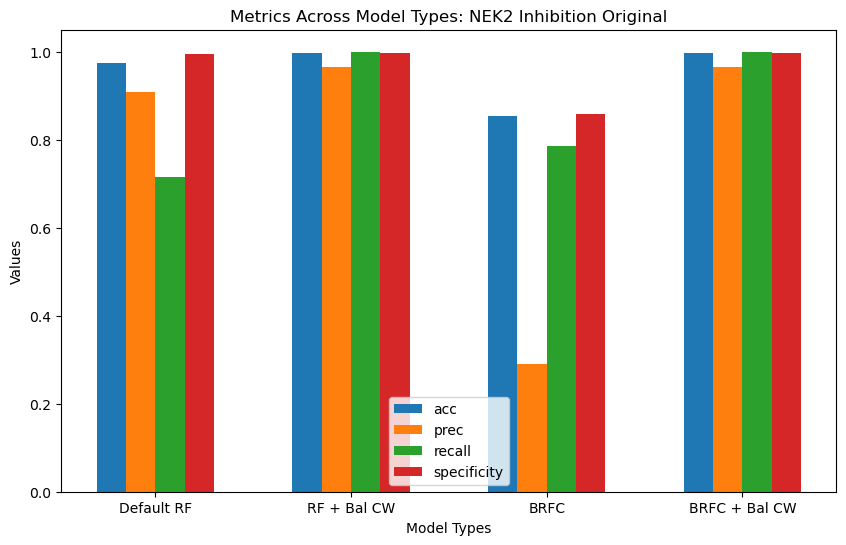

In [119]:
# do each model type: default rf, rf+bal cw, brfc, brfc+bal cw
inhib_original_results = [] 
for model_type, model in inhib_original.items():
    results = rf_results2(model, train_x, train_y, test_x, test_y)
    inhib_original_results.append(results)
plot_metrics_for_models(inhib_original_results, 'NEK2 Inhibition Original')

TRAIN: accuracy: 0.884, precision: 0.816, recall: 0.991, specificity: 0.777
TEST: accuracy: 0.812, precision: 0.231, recall: 0.750, specificity: 0.816
TRAIN: accuracy: 0.879, precision: 0.810, recall: 0.991, specificity: 0.768
TEST: accuracy: 0.807, precision: 0.226, recall: 0.750, specificity: 0.811
TRAIN: accuracy: 0.879, precision: 0.810, recall: 0.991, specificity: 0.768
TEST: accuracy: 0.809, precision: 0.228, recall: 0.750, specificity: 0.814
TRAIN: accuracy: 0.879, precision: 0.810, recall: 0.991, specificity: 0.768
TEST: accuracy: 0.807, precision: 0.226, recall: 0.750, specificity: 0.811


<Figure size 1000x600 with 0 Axes>

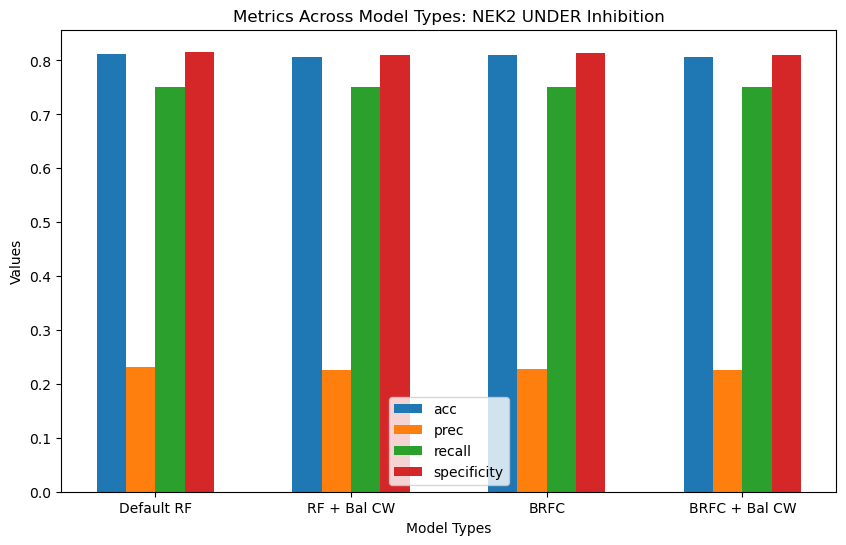

In [120]:
inhib_under_results = [] 
for model_type, model in inhib_under.items():
    results = rf_results2(model, train_x_UNDER, train_y_UNDER, test_x_UNDER, test_y_UNDER)
    inhib_under_results.append(results)
plot_metrics_for_models(inhib_under_results, 'NEK2 UNDER Inhibition')

TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970, specificity: 1.000
TEST: accuracy: 0.932, precision: 0.500, recall: 0.536, specificity: 0.961
TRAIN: accuracy: 0.983, precision: 0.999, recall: 0.967, specificity: 0.999
TEST: accuracy: 0.934, precision: 0.517, recall: 0.536, specificity: 0.963
TRAIN: accuracy: 0.984, precision: 1.000, recall: 0.967, specificity: 1.000
TEST: accuracy: 0.932, precision: 0.500, recall: 0.536, specificity: 0.961
TRAIN: accuracy: 0.989, precision: 1.000, recall: 0.977, specificity: 1.000
TEST: accuracy: 0.939, precision: 0.556, recall: 0.536, specificity: 0.969


<Figure size 1000x600 with 0 Axes>

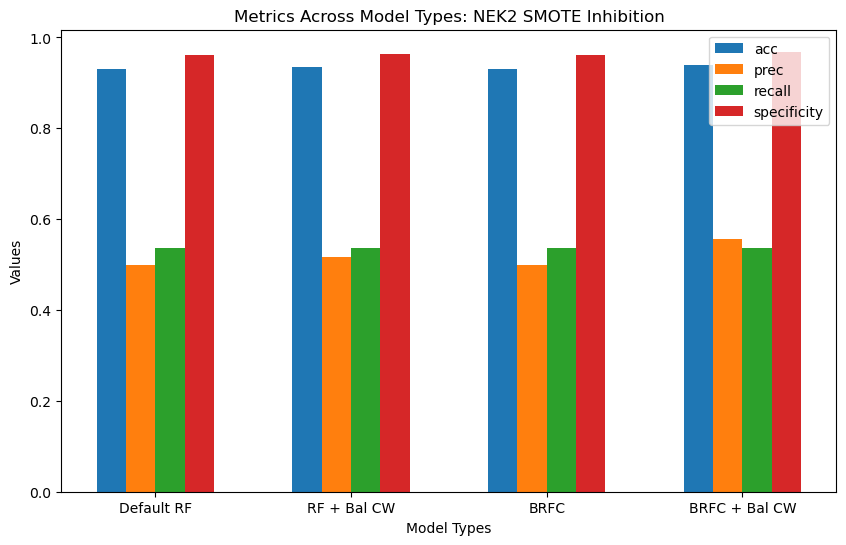

In [121]:
inhib_smote_results = [] 
for model_type, model in inhib_smote.items():
    results = rf_results2(model, train_x_SMOTE, train_y_SMOTE, test_x_SMOTE, test_y_SMOTE)
    inhib_smote_results.append(results)
plot_metrics_for_models(inhib_smote_results, 'NEK2 SMOTE Inhibition')

TRAIN: accuracy: 0.987, precision: 1.000, recall: 0.975, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.367, recall: 0.393, specificity: 0.950
TRAIN: accuracy: 0.986, precision: 0.999, recall: 0.973, specificity: 0.999
TEST: accuracy: 0.910, precision: 0.355, recall: 0.393, specificity: 0.948
TRAIN: accuracy: 0.999, precision: 0.999, recall: 0.999, specificity: 0.999
TEST: accuracy: 0.927, precision: 0.467, recall: 0.500, specificity: 0.958
TRAIN: accuracy: 0.999, precision: 0.999, recall: 0.999, specificity: 0.999
TEST: accuracy: 0.927, precision: 0.467, recall: 0.500, specificity: 0.958


<Figure size 1000x600 with 0 Axes>

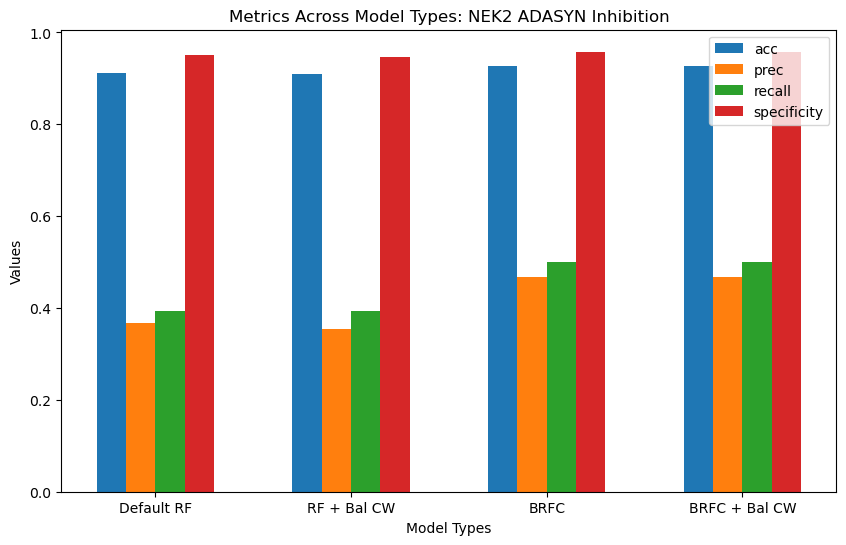

In [122]:
inhib_adasyn_results = [] 
for model_type, model in inhib_adasyn.items():
    results = rf_results2(model, train_x_ADASYN, train_y_ADASYN, test_x_ADASYN, test_y_ADASYN)
    inhib_adasyn_results.append(results)
plot_metrics_for_models(inhib_adasyn_results, 'NEK2 ADASYN Inhibition')

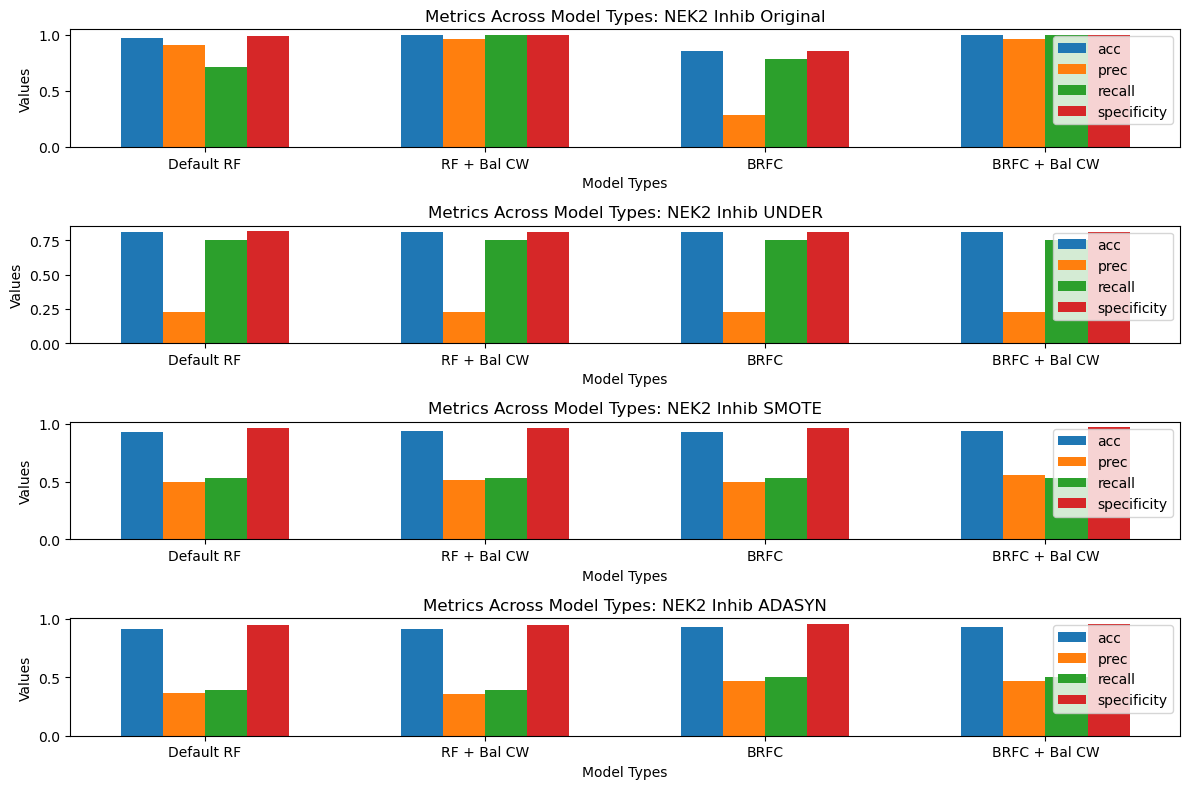

In [123]:
results_lists = [inhib_original_results, inhib_under_results, inhib_smote_results, inhib_adasyn_results]
dataset_titles = ['NEK2 Inhib Original', 'NEK2 Inhib UNDER', 'NEK2 Inhib SMOTE', 'NEK2 Inhib ADASYN']

plot_metrics_for_sampling(results_lists, dataset_titles)


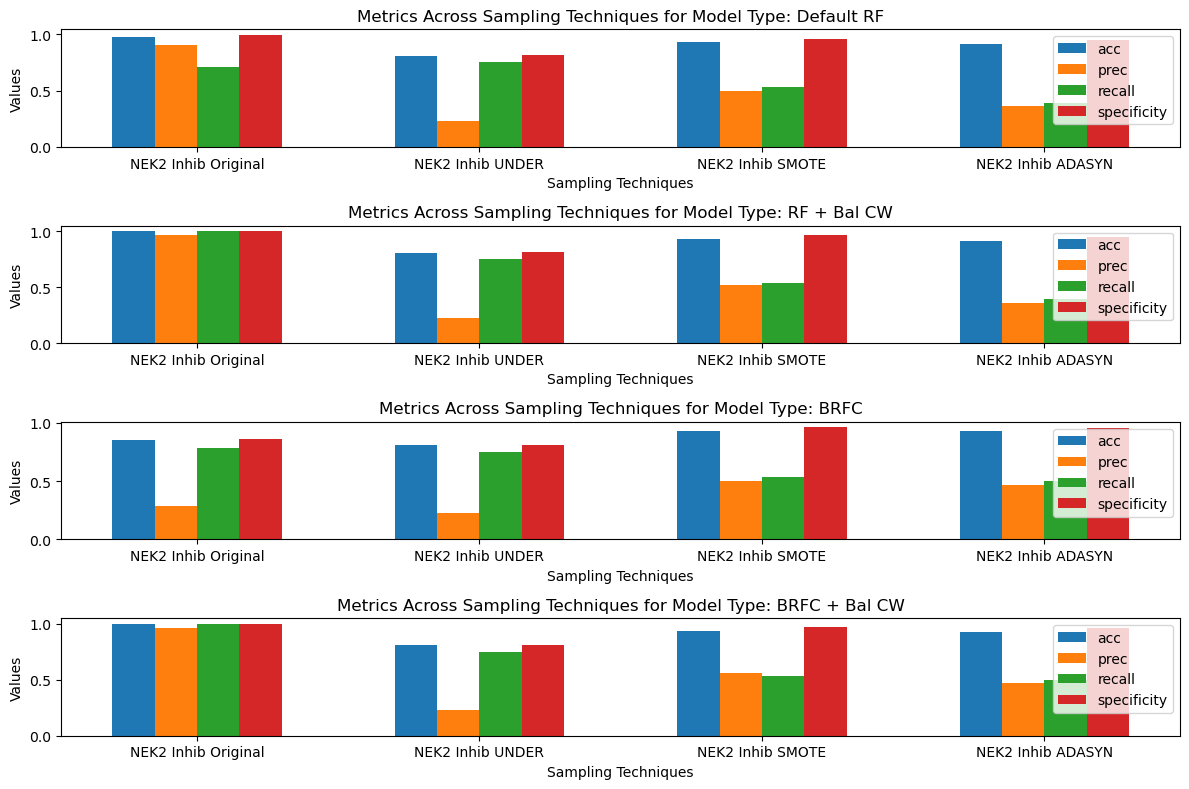

In [124]:
plot_metrics_for_models2(results_lists, dataset_titles)

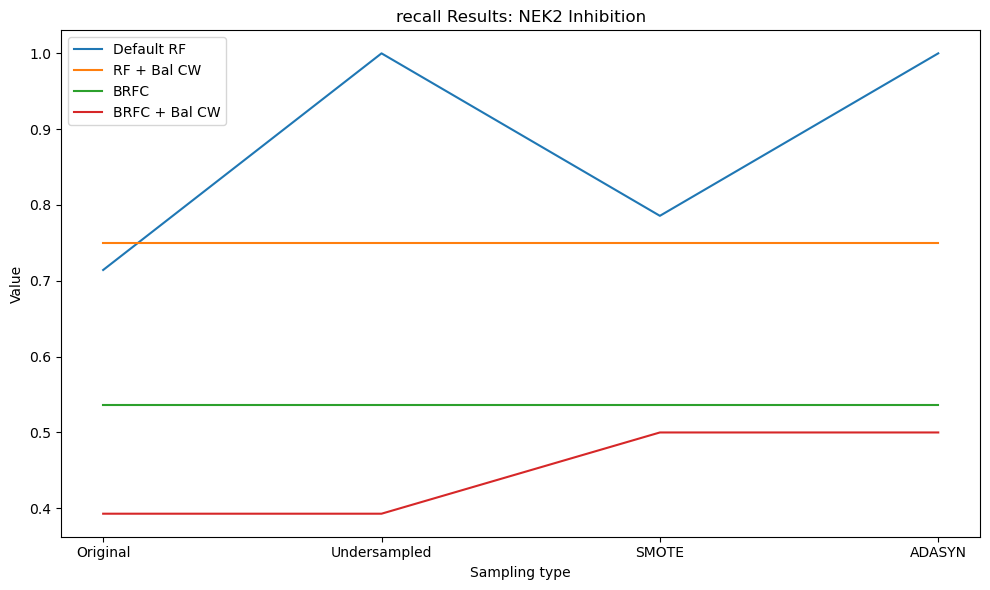

In [125]:
plot_chosen_metric(results_lists, 'recall', 'NEK2 Inhibition')

In [126]:
# temp_nek2bind_MOE_original = {'default_RF':rf_basic100est['model'], 'rf_bcw':brf_model_BCW['model'],
#                               'BRFC': brf_model['model'], 'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2bind_originalmodels.pkl', 'wb') as f:
#     pickle.dump(temp_nek2bind_MOE_original, f)

In [127]:
# # savioNEK2bind_GSCV_basicRF_best.pkl
# with open(modeldir+'atom_nek2bind_rf_basic_best.pkl', 'rb') as f: 
# # with open(modeldir+'savioNEK2bind_GSCV_basicRF_best.pkl', 'rb') as f: 
#     rf_basicbest = pickle.load(f) 
# for param, val in rf_basicbest.get_params().items(): 
#     print(f'{param} : {val}')
# train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(rf_basicbest, train_x, train_y, test_x, test_y)
# plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: Default RF')



# rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
# for param, val in rf_basic100est['model'].get_params().items(): 
#     print(f'{param} : {val}')
# # plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
# plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='NEK2 Binding Test: Basic RF')

In [65]:
# # with open(modeldir+'savioNEK2bind_GSCV_basicRF_best.pkl', 'rb') as f: 
# with open(modeldir+'atom_nek2bind_rf_basicBCW_best.pkl', 'rb') as f: 
#     rf_basicBCWbest = pickle.load(f) 
# for param, val in rf_basicBCWbest.get_params().items(): 
#     print(f'{param} : {val}')
# train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(rf_basicBCWbest, train_x, train_y, test_x, test_y)
# plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: RF+bal c.w')

In [66]:
# # with open(modeldir+'savioNEK2bind_GSCV_basicRF_best.pkl', 'rb') as f: 
# with open(modeldir+'atom_nek2bind_rf_basicBCW_best.pkl', 'rb') as f: 
#     rf_basicBCWbest = pickle.load(f) 
# for param, val in rf_basicBCWbest.get_params().items(): 
#     print(f'{param} : {val}')
# train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(rf_basicBCWbest, train_x, train_y, test_x, test_y)
# plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: RF+bal c.w')

In [83]:

# with open(modeldir+'atom_nek2bind_BRFC_best.pkl', 'rb') as f: 
#     brfc_best = pickle.load(f) 
# for param, val in brfc_best.get_params().items(): 
#     print(f'{param} : {val}')
# train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(brfc_best, train_x, train_y, test_x, test_y)
# plot_confusion_matrix(test_y, test_pred, ['0','1'], title='NEK2 Bind Test: Balanced RF')

In [128]:
saved_results_all_datasets = []

# precision_original = []
# precision_under = []
# precision_smote = []
# precision_adasyn = []

# accuracy_original = []
# accuracy_under = []
# accuracy_smote = []
# accuracy_adasyn = []

# specificity_original = []
# specificity_under = []
# specificity_smote = []
# specificity_adasyn = []
# results_files = ['../nek2_bind_original_results.pkl','../nek2_bind_UNDER_results.pkl','../nek2_bind_SMOTE_results.pkl','../nek2_bind_ADASYN_results.pkl']
# for i, results_file in enumerate(results_files):
#     with open(results_file,'rb') as f:
#         results = pickle.load(f)
#         saved_results_all_datasets.append(results)
#         this_dataset_model_recall = []
#         for i, model_type in enumerate(results):
#             this_dataset_model_recall.append(model_type['test_results']['recall'])
#         recalls.append(this_dataset_model_recall)
# # where recalls has structure: original: default recall, bcw recall, brfc, brfcbcw; under: default recall, bcw recall ...; smote: ...; adasyn: ...
# recall_values = [] 
# dataset_recall_vals = []
# for i, dataset_recalls in enumerate(recalls):
#     dataset_recall_vals.append(dataset_recalls)
#     recall_val = [] 
#     for j, val in enumerate(dataset_recalls): 
#         recall_val.append(val[0])
#     recall_values.append(recall_val)
sampling_types = ['Original', 'UNDER', 'SMOTE', 'ADASYN']
model_types = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
results_files = ['../saved_models/nek2_inhib_original_results.pkl','../saved_models/nek2_inhib_UNDER_results.pkl',
                 '../saved_models/nek2_inhib_SMOTE_results.pkl','../saved_models/nek2_inhib_ADASYN_results.pkl']
for i, results_file in enumerate(results_files):
    with open(results_file,'rb') as f:
        results = pickle.load(f)
        saved_results_all_datasets.append(results)
all_results_original1=saved_results_all_datasets[0]
all_results_under1 = saved_results_all_datasets[1] 
all_results_smote1 = saved_results_all_datasets[2]
all_results_adasyn1 =saved_results_all_datasets[3]
recall_original = [modeli['test_results']['recall'][0] for modeli in all_results_original1]
recall_under = [modeli['test_results']['recall'][0] for modeli in all_results_under1]
recall_smote = [modeli['test_results']['recall'][0] for modeli in all_results_smote1]
recall_adasyn= [modeli['test_results']['recall'][0] for modeli in all_results_adasyn1]

prec_original = [modeli['test_results']['precision'][0] for modeli in all_results_original1]
prec_under = [modeli['test_results']['precision'][0] for modeli in all_results_under1]
prec_smote =[modeli['test_results']['precision'][0] for modeli in all_results_smote1]
prec_smote = [modeli['test_results']['precision'][0] for modeli in all_results_smote1]
prec_adasyn = [modeli['test_results']['precision'][0] for modeli in all_results_adasyn1]

acc_original = [modeli['test_results']['accuracy'][0] for modeli in all_results_original1]
acc_under = [modeli['test_results']['accuracy'][0] for modeli in all_results_under1]
acc_smote = [modeli['test_results']['accuracy'][0] for modeli in all_results_smote1]
acc_adasyn = [modeli['test_results']['accuracy'][0] for modeli in all_results_adasyn1]

spec_original = [modeli['test_results']['specificity'][0] for modeli in all_results_original1]
spec_under = [modeli['test_results']['specificity'][0] for modeli in all_results_under1]
spec_smote = [modeli['test_results']['specificity'][0] for modeli in all_results_smote1]
spec_adasyn = [modeli['test_results']['specificity'][0] for modeli in all_results_adasyn1]

In [129]:

with open('inhib_rf_original_recall', 'wb') as f: 
    pickle.dump(recall_original, f)
with open('inhib_rf_under_recall', 'wb') as f: 
    pickle.dump(recall_under, f) 
with open('inhib_rf_smote_recall', 'wb') as f: 
    pickle.dump(recall_smote, f)
with open('inhib_rf_adasyn_recall', 'wb') as f: 
    pickle.dump(recall_adasyn, f)

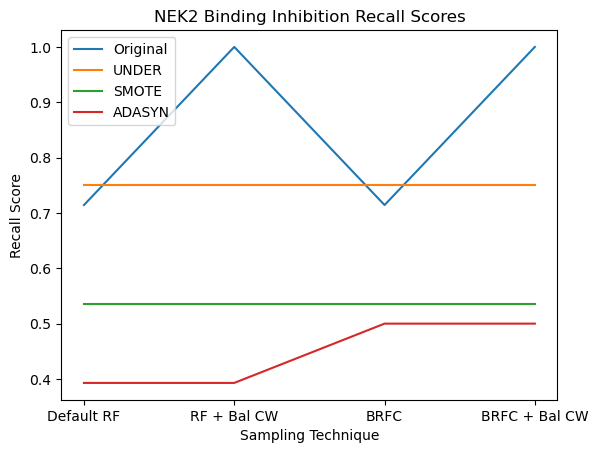

In [90]:
plt.plot(recall_original,label='Original')
plt.plot(recall_under,label='UNDER')
plt.plot(recall_smote,label='SMOTE')
plt.plot(recall_adasyn,label='ADASYN')
plt.xlabel('Sampling Technique')
plt.ylabel('Recall Score')
plt.xticks(range(4), model_types)
plt.title('NEK2 Binding Inhibition Recall Scores')
plt.legend()
plt.show();

In [27]:
# default_results = []
# defaultbcw_results =[] 
# brfc_results = []
# brfcbcw_results = [] 
# recalls = []
# accuracies = []
# precisions = [] 
# specificities = [] 
# dataset_type_results2 = []
# model_types = []
# model_type_results = [] 

In [61]:

# for i, results in enumerate(saved_results_all_datasets):
#     model_type_results = []
#     for model_type1of4 in results:
#         model_type_results.append(model_type1of4['test_results'])
        
#     for modelj in model_type_results:
#         recall = modelj['recall'][0]
#         precision = modelj['precision'][0]
#         accuracy = modelj['accuracy'][0]
#         specificity = modelj['specificity'][0]

#         if i == 0:
#             recall_original.append(recall)
#             precision_original.append(precision)
#             accuracy_original.append(accuracy)
#             specificity_original.append(specificity)
#         elif i == 1:
#             recall_under.append(recall)
#             precision_under.append(precision)
#             accuracy_under.append(accuracy)
#             specificity_under.append(specificity)
#         elif i == 2:
#             recall_smote.append(recall)
#             precision_smote.append(precision)
#             accuracy_smote.append(accuracy)
#             specificity_smote.append(specificity)
#         elif i == 3:
#             recall_adasyn.append(recall)
#             precision_adasyn.append(precision)
#             accuracy_adasyn.append(accuracy)
#             specificity_adasyn.append(specificity)

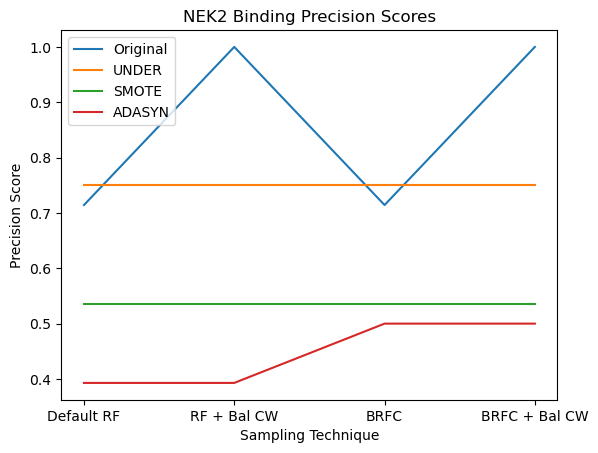

In [86]:
plt.plot(prec_original,label='Original')
plt.plot(prec_under,label='UNDER')
plt.plot(prec_smote,label='SMOTE')
plt.plot(prec_adasyn,label='ADASYN')
plt.xlabel('Sampling Technique')
plt.ylabel('Precision Score')
plt.xticks(range(4), model_types)
plt.title('NEK2 Binding Precision Scores')
plt.legend()
plt.show();

In [38]:
# saved_results_all_datasets
# for i, dataset_type in enumerate(saved_results_all_datasets):
#     dataset_type_results2.append(dataset_type)
#     this_dataset_model_type_results = [] 
#     datasettype_accs = [] 
#     datasettype_precs = []
#     datasettype_recalls = [] 
#     datasettype_specfs = []
#     for j, model_type1of4 in enumerate(dataset_type): 
#         this_dataset_model_type_results.append(model_type1of4['test_results'])
#         print(model_type1of4['test_results']['recall'][0])
#         print(j)
#         accs = [modelj['test_results']['accuracy'][0] for modelj in model_type1of4]
#         precs = [modelj['test_results']['precision'][0] for modelj in model_type1of4]
#         recs = [modelj['test_results']['recall'][0] for modelj in model_type1of4]
#         specs = [modelj['test_results']['specificity'][0] for modelj in model_type1of4]
#         datasettype_accs.append(accs)
#         datasettype_precs.append(precs)
#         datasettype_recalls.append(recs)
#         datasettype_specfs.append(specs)
#     model_type_results.append(this_dataset_model_type_results)
#     recalls.append(datasettype_recalls) 
#     accuracies.append(datasettype_accs) 
#     precisions.append(datasettype_precs)
#     specificities.append(datasettype_specfs) 


0.0
0


TypeError: string indices must be integers

In [37]:
recalls


[[<generator object <genexpr> at 0x34a2eb350>,
  <generator object <genexpr> at 0x34a2eb740>,
  <generator object <genexpr> at 0x34a2eb9e0>,
  <generator object <genexpr> at 0x34a2ebb30>],
 [<generator object <genexpr> at 0x34a2ebcf0>,
  <generator object <genexpr> at 0x34a2ebeb0>,
  <generator object <genexpr> at 0x34a2d90b0>,
  <generator object <genexpr> at 0x34a2d9270>],
 [<generator object <genexpr> at 0x34a2d9430>,
  <generator object <genexpr> at 0x34a2d95f0>,
  <generator object <genexpr> at 0x34a2d97b0>,
  <generator object <genexpr> at 0x34a2d9970>],
 [<generator object <genexpr> at 0x34a2d9b30>,
  <generator object <genexpr> at 0x34a2d9cf0>,
  <generator object <genexpr> at 0x34a2d9eb0>,
  <generator object <genexpr> at 0x34a2d40b0>],
 [[0.0], [0.16666666666666666], [0.6666666666666666], [0.5833333333333334]],
 [[0.6666666666666666],
  [0.6666666666666666],
  [0.6666666666666666],
  [0.9166666666666666]],
 [[0.3333333333333333],
  [0.3333333333333333],
  [0.4166666666666667]

In [155]:
type(model_type_results[0][1])
model_type_results[0][1]['accuracy'][0]

0.9397163120567376

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (4, 282).

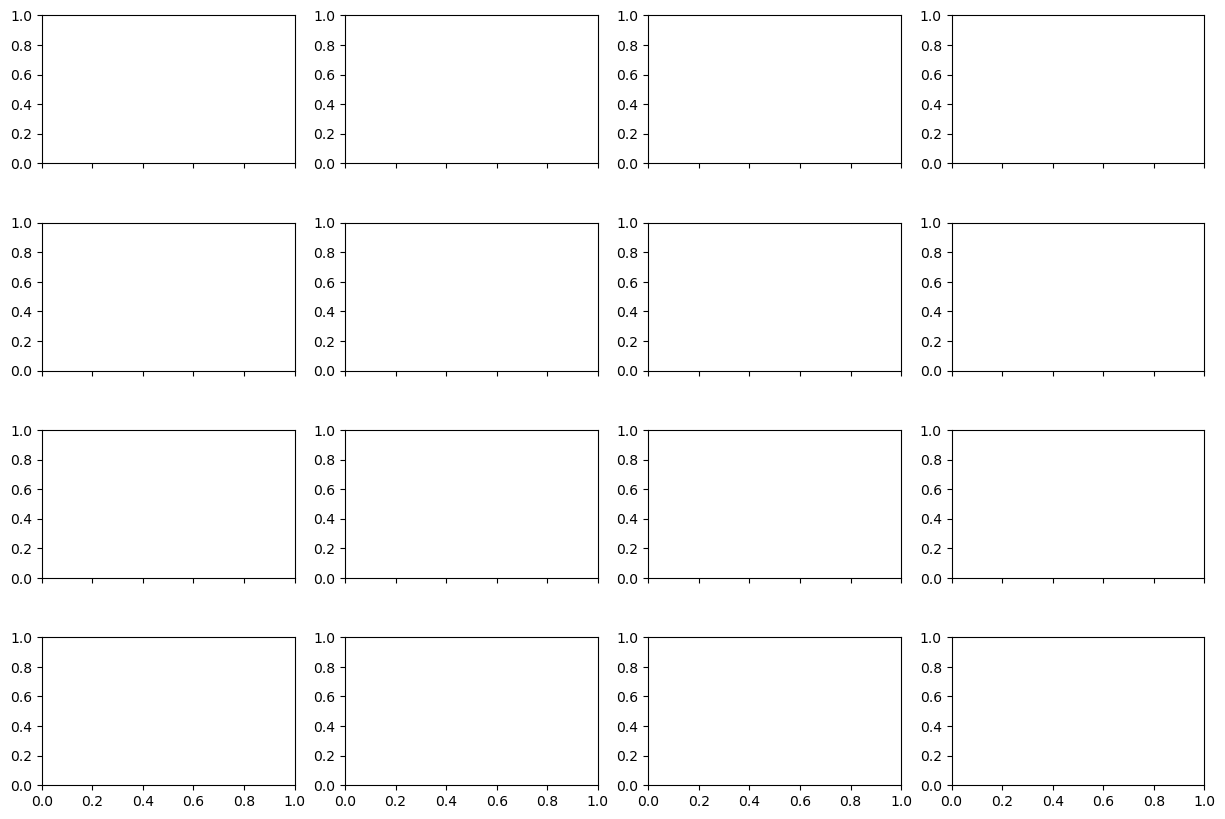

In [142]:
sampling_types = ['Original', 'UNDER', 'SMOTE', 'ADASYN']
model_types = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
metrics = ['accuracy', 'precision', 'recall', 'specificity']
num_datasets = len(sampling_types)
num_metrics = len(metrics)

fig, axes = plt.subplots(num_datasets, num_metrics, figsize=(15, 10), sharex='col')
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        metric = metrics[j]
        values = [model_type_results[i][k][metric] for k in range(len(model_type_results[i]))]
        ax.bar(range(len(values)), values, color='skyblue')
        ax.set_title(f'{metric.capitalize()} - {dataset_types[i]}')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels([f'Model {k+1}' for k in range(len(values))])

plt.show()


In [ ]:
model_names = ['Default RF', 'RF + Bal CW', 'BRFC', 'BRFC + Bal CW']
metrics = ['accuracy', 'precision', 'recall', 'specificity']
num_metrics = len(metrics)
num_models = len(model_names)

metric_values = np.zeros((num_models, num_metrics))
for i, results in enumerate(results_list):
    for j, metric in enumerate(metrics):
        metric_values[i, j] = results['test_'+metric]
bar_width = 0.15
index = np.arange(num_models)
plt.figure(figsize=(10, 6))
for i in range(num_metrics):
    plt.bar(index + i * bar_width, metric_values[:, i], bar_width, label=metrics[i])

plt.xlabel('Model Types')
plt.ylabel('Values')
plt.title(f'Metrics Across Model Types: {dataset_title}')
plt.xticks(index + bar_width *(num_metrics - 1)/2, model_names)
plt.legend()
plt.show()